# Setup

In [1]:
!pip install osfclient --quiet
!pip install keras_cv --quiet
!pip install plotnine --quiet
!pip install wandb --quiet
!pip install keras-hub --quiet
!pip install dotenv --quiet
!pip install scikit-learn --quiet





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.2 MB/s eta 0:00:00


In [2]:
import os
import tensorflow as tf
import numpy as np

import keras
from keras import ops
import keras_hub

import pandas as pd
import osfclient
from osfclient.api import OSF

import wandb
from wandb.integration.keras import WandbMetricsLogger

from plotnine import ggplot, geom_point, aes, geom_line, geom_histogram, geom_boxplot, geom_ribbon, scale_y_reverse, scale_y_continuous, theme_void, scale_x_continuous, scale_color_manual, scale_fill_manual, ylab, xlab, labs, theme, theme_classic, element_text, element_blank, element_line, facet_wrap

In [3]:
try:
  from google.colab import userdata
  IN_COLAB = True
except ImportError:
  IN_COLAB = False

In [4]:
!pip install git+https://github.com/jspsych/eyetracking-utils.git@v0.3.0 --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.custom_layers import (
    SimpleTimeDistributed,
    MaskedWeightedRidgeRegressionLayer,
    MaskInspectorLayer,
)
from et_util.model_analysis import plot_model_performance

In [6]:
if IN_COLAB:
    os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
    os.environ['OSF_TOKEN'] = userdata.get('osftoken')
    os.environ['OSF_USERNAME'] = userdata.get('osfusername')
else:
    # Load from a .env file using python-dotenv
    from dotenv import load_dotenv
    load_dotenv()
    os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY', '')
    os.environ['OSF_TOKEN'] = os.getenv('OSF_TOKEN', '')
    os.environ['OSF_USERNAME'] = os.getenv('OSF_USERNAME', '')

os.environ['OSF_ANALYSIS_PROJECT_ID'] = "8ecx5"
os.environ["KERAS_BACKEND"] = "tensorflow"

# Configure W&B experiment

In [7]:
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [8]:
EXPERIMENT_ID = "gf1zjs9v"
ENTITY_NAME = "vassar-cogsci-lab"
PROJECT_NAME = "eye-tracking-dense-full-data-set-single-eye"

# Resume the W&B run to add new data
wandb.init(entity=ENTITY_NAME, project=PROJECT_NAME, id=EXPERIMENT_ID, resume="must")

# Download the Model Config and Weights File from W&B

In [9]:
api = wandb.Api()

run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{EXPERIMENT_ID}")

config = run.config

# Download the full serialized model (new format)
run.file("full_model.keras").download(exist_ok=True)

# Also download weights for backwards compatibility if needed
try:
    run.file("full_model.weights.h5").download(exist_ok=True)
except:
    pass

EMBEDDING_DIM = config["embedding_dim"]
RIDGE_REGULARIZATION = config["ridge_regularization"]

In [10]:
# Fixed constants
MAX_TARGETS = 288

# Config constants
EMBEDDING_DIM = config['embedding_dim']
RIDGE_REGULARIZATION = config['ridge_regularization']

BACKBONE = config['backbone']

# Configure OSF Analysis Component Client

In [11]:
analysis_osf = osfclient.OSF(token=os.environ['OSF_TOKEN'])

In [12]:
analysis_osf_project = analysis_osf.project(os.environ['OSF_ANALYSIS_PROJECT_ID'])

## Function for saving files locally and uploading to OSF

In [13]:
def upload_to_analysis_osf(analysis_folder, fps):
  for fp in fps:
    local_fp = os.path.join('/content/' + analysis_folder, fp)
    remote_fp = os.path.join(analysis_folder, fp)
    with open(local_fp, 'rb') as f:
      analysis_osf_project.storage().create_file(remote_fp, fp=f, update=True)

# Dataset preparation

## Download dataset from OSF

In [14]:
os.environ['OSF_TOKEN']

'Cvv9AY4YAA43Lb17ua0cbUr0G4OAv5mvFmegj7RK8e3k4vJZt5H7AihU6nvJxVQdkdxeW3'

In [15]:
!osf fetch

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: the following arguments are required: remote


In [16]:
!osf -p uf2sh fetch single_eye_tfrecords.tar.gz

100% 675M/675M [00:13<00:00, 49.9Mbytes/s]


# Process raw data records into TF Dataset

In [17]:
!mkdir single_eye_tfrecords
!tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [18]:
def parse(element):
    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'phase': tf.io.FixedLenFeature([], tf.int64),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    #landmarks = content['landmarks']
    raw_image = content['eye_img']
    width = content['img_width']
    height = content['img_height']
    phase = content['phase']
    depth = 3
    coords = [content['x'], content['y']]
    subject_id = content['subject_id']

    # landmarks = tf.io.parse_tensor(landmarks, out_type=tf.float32)
    # landmarks = tf.reshape(landmarks, shape=(478, 3))

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, phase, coords, subject_id

In [19]:
test_data, _, _ = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, phase, coords, subject_id: subject_id
)

## Rescale the `x,y` coordinates to be 0-1 instead of 0-100.

In [20]:
def rescale_coords_map(img, phase, coords, id):
  return img, phase, tf.divide(coords, tf.constant([100.])), id

In [21]:
test_data_rescaled = test_data.map(rescale_coords_map)

## Prepared masked dataset with phase calibration info

In [22]:
def prepare_masked_dataset(dataset, calibration_points=None, cal_phase=None):
    # Step 1: Group dataset by subject_id and batch all images
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, phase, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    # Step 2: Filter out subjects with not enough data points （288 total; 144 in each phase)
    def filter_by_image_count(images, phase, coords, subject_ids):
        total_image_count = tf.shape(images)[0] >= MAX_TARGETS
        phase1_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 1), tf.int32)) >= 144
        phase2_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 2), tf.int32)) >= 144
        return tf.logical_and(total_image_count, tf.logical_and(phase1_image_count, phase2_image_count))

   # grouped_dataset = grouped_dataset.filter(filter_by_image_count)

    # Step 3: Transform each batch to include masks
    def add_masks_to_batch(images, phase, coords, subject_ids):

        actual_batch_size = tf.shape(images)[0] # how many total images for a given subject

        print(f'actual_batch_size: {actual_batch_size}')

        # Create phase masks
        phase1_mask = tf.cast(tf.equal(phase, 1), tf.int8)
        phase2_mask = tf.cast(tf.equal(phase, 2), tf.int8)

        cal_mask = tf.zeros(actual_batch_size, dtype=tf.int8)
        target_mask = tf.zeros(actual_batch_size, dtype=tf.int8)

        if calibration_points is None:
          raise ValueError("Need to specify calibration points in test mode")
        else:
          coords_xpand = tf.expand_dims(coords, axis=1)
          cal_xpand = tf.expand_dims(calibration_points, axis=0)

          # Check which points match calibration points
          equality = tf.equal(coords_xpand, cal_xpand)
          matches = tf.reduce_all(equality, axis=-1)
          point_matches = tf.reduce_any(matches, axis=1)
          cal_mask = tf.cast(point_matches, dtype=tf.int8)

        target_mask = (1 - cal_mask) * phase2_mask

        if cal_phase == 1:
          cal_mask = cal_mask * phase1_mask
        elif cal_phase == 2:
          cal_mask = cal_mask * phase2_mask

        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(
            coords,
            [[0, MAX_TARGETS - actual_batch_size], [0, 0]]
        )
        padded_cal_mask = tf.pad(
            cal_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )
        padded_target_mask = tf.pad(
            target_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )

        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(padded_cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(padded_target_mask, [MAX_TARGETS])
        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids[0]

    masked_dataset = grouped_dataset.map(
        lambda imgs, phase, coords, subj_ids: add_masks_to_batch(imgs, phase, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset

In [23]:
def get_subject_id_list(features, labels, subject_ids):
  return subject_ids

In [24]:
def prepare_model_inputs(features, labels, subject_ids):
    images, coords, cal_mask, target_mask = features

    inputs = {
        "Input_All_Images": images,
        "Input_All_Coords": coords,
        "Input_Calibration_Mask": cal_mask,
        "Input_Target_Mask": target_mask
    }

    return inputs, labels, target_mask

In [25]:
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

In [26]:
masked_dataset_p1 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 1)

masked_dataset_p2 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 2)

masked_dataset_subject_ids = masked_dataset_p1.map(get_subject_id_list)

actual_batch_size: Tensor("strided_slice:0", shape=(), dtype=int32)
actual_batch_size: Tensor("strided_slice:0", shape=(), dtype=int32)


In [27]:
subject_ids = []
for e in masked_dataset_subject_ids.as_numpy_iterator():
  subject_ids.append(e)
subject_ids = np.array(subject_ids).astype(int)

In [28]:
test_ds_p1 = masked_dataset_p1.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds_p2 = masked_dataset_p2.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [29]:
# Should be the same for either phase cal choices
SUBJECTS = 0
for e in test_ds_p1.as_numpy_iterator():
  SUBJECTS += 1

In [30]:
SUBJECTS

250

# Load Model

Load the serialized model directly using Keras. Custom layers are registered automatically when et_util is imported.

In [39]:
# Load the serialized model - custom objects are registered via et_util import
full_model = keras.models.load_model('full_model.keras')
full_model.summary()

# Compile for evaluation
full_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=normalized_weighted_euc_dist,
    metrics=[normalized_weighted_euc_dist],
    jit_compile=False
)

Model: "MaskedEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_All_Images    │ (None, 288, 36,   │          0 │ -                 │
│ (InputLayer)        │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Embeddings    │ (None, 288, 200)  │  1,581,896 │ Input_All_Images… │
│ (SimpleTimeDistrib… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_All_Coords    │ (None, 288, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Calibration_Weights │ (None, 288, 1)    │        201 │ Image_Embeddings… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Calibration_… │ (None, 288)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Regression          │ (None, 288, 2)    │          0 │ Image_Embeddings… │
│ (MaskedWeightedRid… │                   │            │ Input_All_Coords… │
│                     │                   │            │ Calibration_Weig… │
│                     │                   │            │ Input_Calibratio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

# Analysis \#1: Build Comprehensive Predictions DataFrame and P1 vs P2 Subject Mean Loss Distribution

Create a comprehensive DataFrame containing all predictions and actual coordinates, then analyze phase differences.

In [40]:
def build_predictions_dataframe():
    """
    Build a comprehensive DataFrame with subject_id, predicted coordinates,
    and actual coordinates for both phases. Generates predictions internally.
    """
    all_data = []

    print("Generating Phase 1 predictions...")
    pred_p1_internal = full_model.predict(test_ds_p1.batch(5))

    print("Generating Phase 2 predictions...")
    pred_p2_internal = full_model.predict(test_ds_p2.batch(5))

    print("Processing Phase 1 data...")
    for subject_idx, (pred_batch, ds_batch) in enumerate(zip(pred_p1_internal, test_ds_p1.batch(1).as_numpy_iterator())):
        subject_id = subject_ids[subject_idx]
        actual_coords = ds_batch[1].squeeze()  # Remove batch dimension
        mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

        # Filter by mask to get only target points
        pred_coords = pred_batch[mask == 1]
        actual_coords_filtered = actual_coords[mask == 1]

        # Store data for this subject and phase
        for point_idx, (pred_coord, actual_coord) in enumerate(zip(pred_coords, actual_coords_filtered)):
            error = normalized_weighted_euc_dist(
                np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
            )
            error_float = float(error.numpy()[0])  # Convert tensor to float

            all_data.append({
                'subject_id': subject_id,
                'point_id': point_idx,
                'x_actual': actual_coord[0],
                'y_actual': actual_coord[1],
                'x_predicted': pred_coord[0],
                'y_predicted': pred_coord[1],
                'calibration_phase': 1,
                'error': error_float
            })

    print("Processing Phase 2 data...")
    for subject_idx, (pred_batch, ds_batch) in enumerate(zip(pred_p2_internal, test_ds_p2.batch(1).as_numpy_iterator())):
        subject_id = subject_ids[subject_idx]
        actual_coords = ds_batch[1].squeeze()  # Remove batch dimension
        mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

        # Filter by mask to get only target points
        pred_coords = pred_batch[mask == 1]
        actual_coords_filtered = actual_coords[mask == 1]

        # Store data for this subject and phase
        for point_idx, (pred_coord, actual_coord) in enumerate(zip(pred_coords, actual_coords_filtered)):
            error = normalized_weighted_euc_dist(
                np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
            )
            error_float = float(error.numpy()[0])  # Convert tensor to float

            all_data.append({
                'subject_id': subject_id,
                'point_id': point_idx,
                'x_actual': actual_coord[0],
                'y_actual': actual_coord[1],
                'x_predicted': pred_coord[0],
                'y_predicted': pred_coord[1],
                'calibration_phase': 2,
                'error': error_float
            })

    # Convert to DataFrame
    df = pd.DataFrame(all_data)

    print(f"DataFrame created with {len(df)} rows, {len(df['subject_id'].unique())} unique subjects, and phases {df['calibration_phase'].unique()}")
    return df

# Build the comprehensive predictions DataFrame
predictions_df = build_predictions_dataframe()
predictions_df.head()

Generating Phase 1 predictions...
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step
Generating Phase 2 predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step
Processing Phase 1 data...
Processing Phase 2 data...
DataFrame created with 57322 rows, 246 unique subjects, and phases [1 2]


,subject_id,point_id,x_actual,y_actual,x_predicted,y_predicted,calibration_phase,error
0,2035953160437,0,0.47,0.1625,0.500402,0.231996,1,4.315976
1,2035953160437,1,0.29,0.8375,0.665133,0.667340,1,33.743935
2,2035953160437,2,0.11,0.1625,0.128779,0.513728,1,17.295372
3,2035953160437,3,0.23,0.6125,0.326517,0.461776,1,11.196516
4,2035953160437,4,0.23,0.7250,0.216081,0.923191,1,9.791077


## Calculate subject-level statistics and create loss distributions

In [41]:
# Calculate subject-level statistics from predictions_df including sample counts
subject_stats = (
    predictions_df
    .groupby(['subject_id', 'calibration_phase'])
    .agg({'error': 'mean', 'point_id': 'count'})
    .reset_index()
    .pivot(index='subject_id', columns='calibration_phase', values=['error', 'point_id'])
    .reset_index()
)

# Flatten column names
subject_stats.columns = ['subject_id', 'mean_error_p1', 'mean_error_p2', 'n_samples_p1', 'n_samples_p2']

# Filter out subjects with less than 96 samples in either phase
subject_stats_filtered = subject_stats[
    (subject_stats['n_samples_p1'] >= 96) &
    (subject_stats['n_samples_p2'] >= 96)
].copy()

print(f"Total subjects: {len(subject_stats)}")
print(f"Subjects with >= 96 samples in both phases: {len(subject_stats_filtered)}")

# Extract mean losses for plotting (using filtered subjects)
subj_mean_losses_p1 = subject_stats_filtered['mean_error_p1'].tolist()
subj_mean_losses_p2 = subject_stats_filtered['mean_error_p2'].tolist()
filtered_subject_ids = subject_stats_filtered['subject_id'].tolist()

print(f"Using {len(subj_mean_losses_p1)} subjects for analysis")

Total subjects: 246
Subjects with >= 96 samples in both phases: 224
Using 224 subjects for analysis


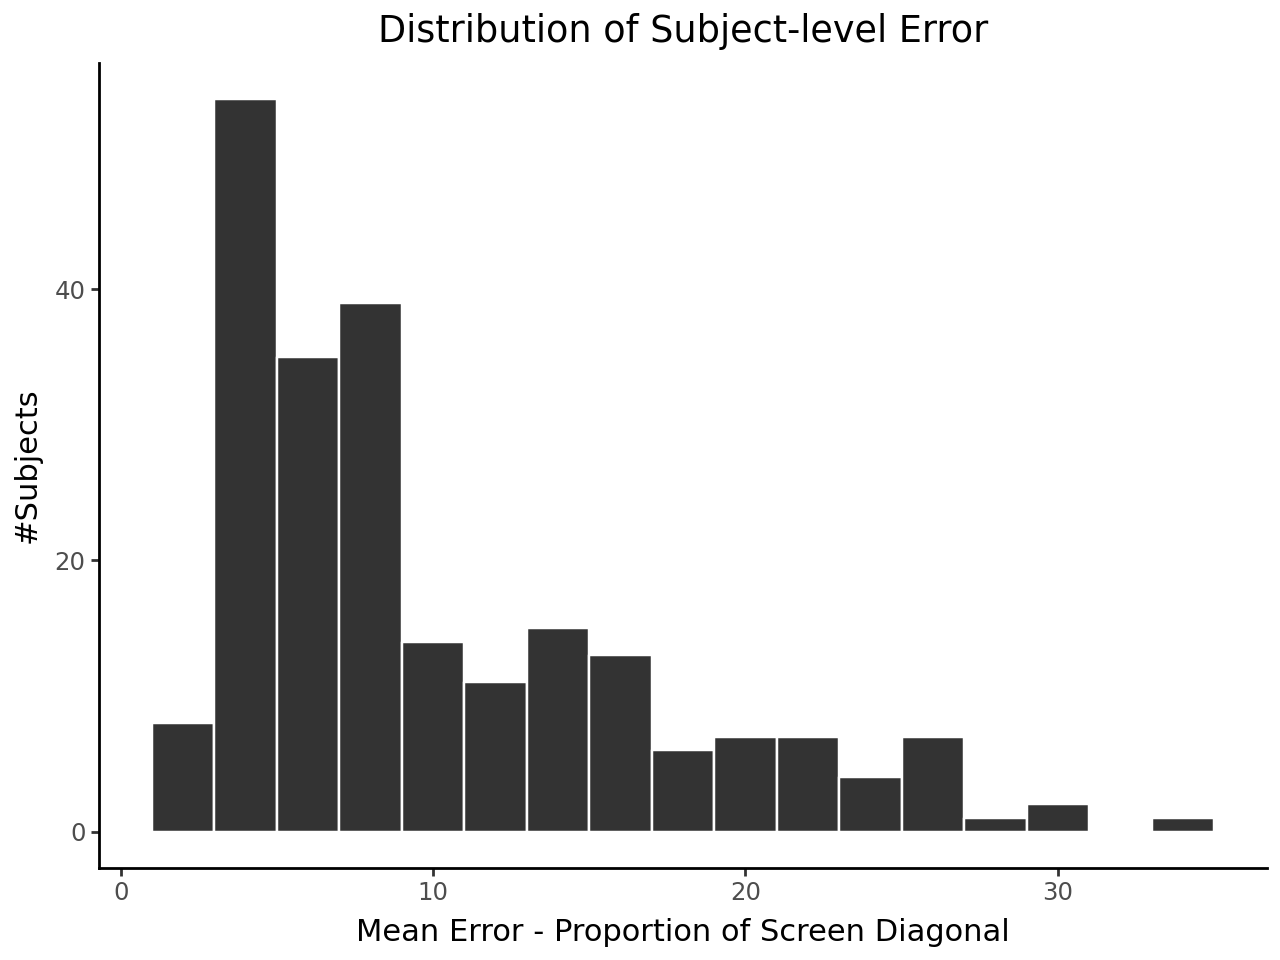

In [47]:
# Create individual phase histograms
subj_mean_losses_df_p1 = pd.DataFrame({'mean_loss': subj_mean_losses_p1})

subj_mean_losses_plot_p1 = (ggplot(subj_mean_losses_df_p1, aes(x='mean_loss'))
 + geom_histogram(binwidth=2, color='white', fill='#333')
 + labs(title='Distribution of Subject-level Error',
       x='Mean Error - Proportion of Screen Diagonal',
       y='#Subjects')
 + theme_classic()
)

subj_mean_losses_df_p2 = pd.DataFrame({'mean_loss': subj_mean_losses_p2})

subj_mean_losses_plot_p2 = (ggplot(subj_mean_losses_df_p2, aes(x='mean_loss'))
 + geom_histogram(binwidth=2, color='white', fill='#333')
 + labs(title='Distribution of Subject Mean Model Loss\n(Calibration with Phase 2 Points)',
       x='Mean Loss - Proportion of Screen Diagonal',
       y='#Subjects')
 + theme_classic()
)

subj_mean_losses_plot_p1

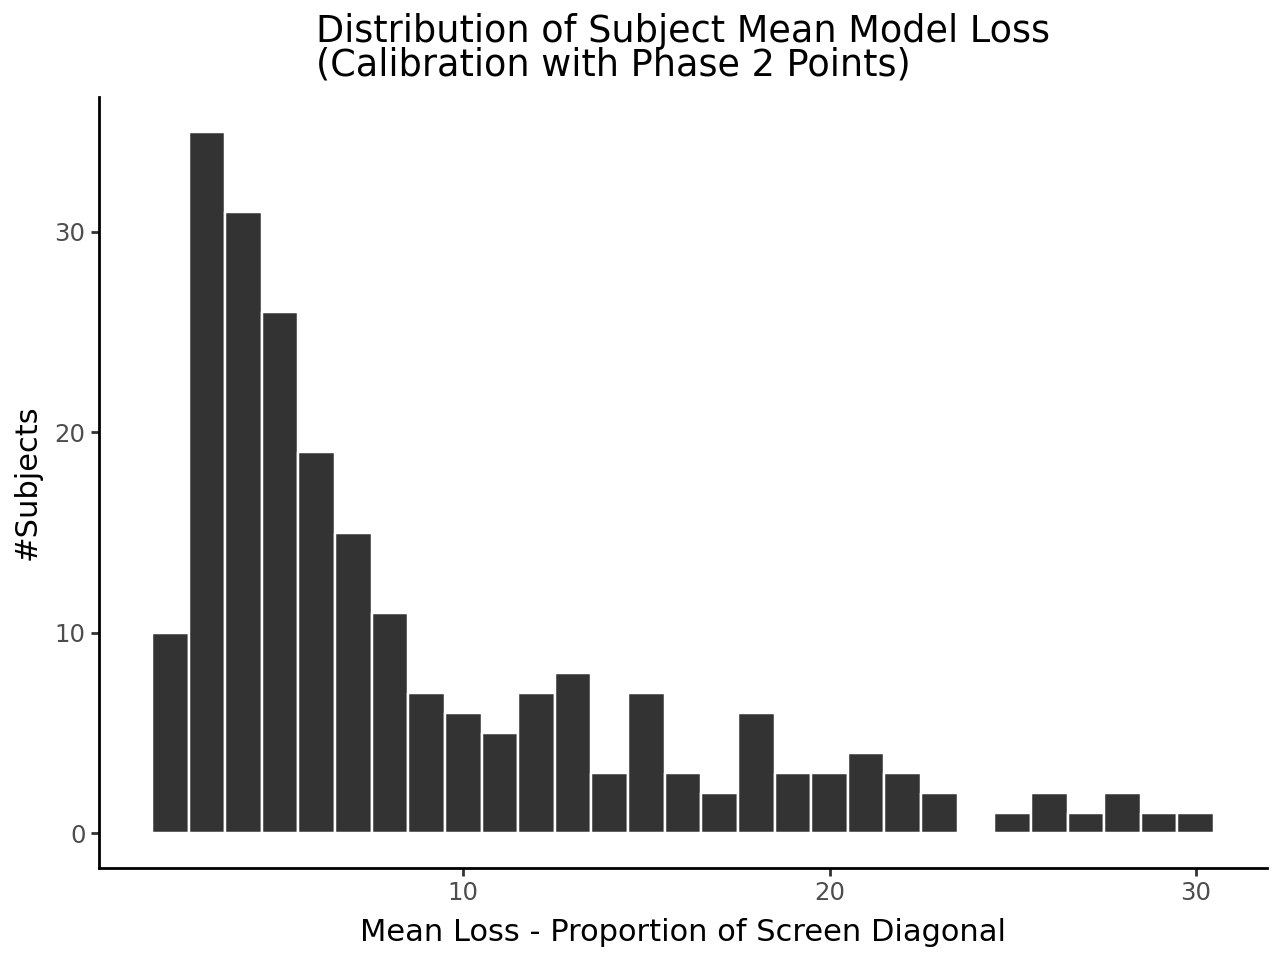

In [43]:
subj_mean_losses_plot_p2

## Create composite histogram

In [ ]:
composite_table = pd.DataFrame({'subject_id': filtered_subject_ids, 'mean_loss_p1': subj_mean_losses_p1, 'mean_loss_p2': subj_mean_losses_p2})
composite_table_pivot_long = composite_table.melt(id_vars=['subject_id'], var_name='phase', value_name='mean_loss')

composite_plot = (ggplot(composite_table_pivot_long, aes(x='mean_loss', fill='phase'))
 + geom_histogram(binwidth=2, alpha=0.5, color='white', position="identity")
 + labs(title='Prediction Error Distributions',
       x='Mean Prediction Error (Percent of Screen Diagonal)',
       y='# Subjects')
 + scale_fill_manual(values=["#69b3a2", "#404080"], labels=["Phase 1", "Phase 2"], name="Calibration Phase")
 + theme_classic()
)

composite_plot

## Upload Analysis \#1 data to W&B

In [ ]:
# Create table with subject, phase 1 loss, and phase 2 loss (using filtered subjects)
analysis_1_table = wandb.Table(columns=["subject_id", "phase_1_loss", "phase_2_loss"], data=list(zip(filtered_subject_ids, subj_mean_losses_p1, subj_mean_losses_p2)))

In [ ]:
wandb.log({"analysis_1_table": analysis_1_table})

In [ ]:
# convert plotnine to image and save as image
composite_plot.save('analysis_1_composite_plot.png', width=10, height=5)
wandb.log({"analysis_1_histogram": wandb.Image('analysis_1_composite_plot.png')})

# Analysis #2: Image Quality metrics vs. accuracy

## Download the image quality metrics from OSF

In [ ]:
!osf -p uf2sh fetch image-quality-metrics-subject-level.csv

In [ ]:
df_image_quality = pd.read_csv('image-quality-metrics-subject-level.csv')

In [ ]:
df_image_quality.head()

In [ ]:
# Use the subject statistics from Analysis #1
df_analysis_2 = subject_stats_filtered[['subject_id', 'mean_error_p1', 'mean_error_p2']].copy()

In [ ]:
# merge image quality data
df_analysis_2 = df_analysis_2.merge(df_image_quality, on='subject_id')

## Compute correlation between image quality metrics and accuracy at subject level

In [ ]:
# run correlations for mean_loss against each quality measure
df_analysis_2.corr()

# Analysis #3: Accuracy plots for individual subjects

## Create Plotting Function Using DataFrame

In [56]:
def plot_predictions_vs_actual_from_df(df, title_suffix=""):
    """
    Plot predicted vs actual coordinates with connecting lines using DataFrame.
    Produces plots for the specified subject(s) and filters for Phase 1 data.
    Facets by 'subject_label'.
    """
    # Filter data for Phase 1
    subject_data = df[df['calibration_phase'] == 1].copy()
    if len(subject_data) == 0:
        print("No Phase 1 data found in the provided DataFrame.")
        return None

    # Prepare data for plotting
    plot_data = []
    line_data = []

    for _, row in subject_data.iterrows():
        subject_label = row['subject_label'] # Use the new subject_label column
        phase = f"Phase {row['calibration_phase']}"
        point_id = row['point_id']

        # Add actual point
        plot_data.append({
            'subject_label': subject_label, # Use subject_label for plotting
            'x': row['x_actual'],
            'y': row['y_actual'],
            'point_type': 'Actual',
            'point_id': point_id
        })

        # Add predicted point
        plot_data.append({
            'subject_label': subject_label, # Use subject_label for plotting
            'x': row['x_predicted'],
            'y': row['y_predicted'],
            'point_type': 'Predicted',
            'point_id': point_id
        })

        # Add line data (two points per line: actual and predicted)
        line_data.extend([
            {
                'subject_label': subject_label, # Use subject_label for plotting
                'x': row['x_actual'],
                'y': row['y_actual'],
                'group': f"{subject_label}_{phase}_{point_id}"
            },
            {
                'subject_label': subject_label, # Use subject_label for plotting
                'x': row['x_predicted'],
                'y': row['y_predicted'],
                'group': f"{subject_label}_{phase}_{point_id}"
            }
        ])

    plot_df = pd.DataFrame(plot_data)
    lines_df = pd.DataFrame(line_data)

    # Create the plot
    plot = (
        ggplot()
        + geom_line(lines_df, aes(x="x", y="y", group="group"), color="darkred", alpha=0.6)
        + geom_point(plot_df[plot_df['point_type'] == 'Actual'],
                    aes(x="x", y="y"), color="gray", size=3, alpha=0.8)
        + geom_point(plot_df[plot_df['point_type'] == 'Predicted'],
                    aes(x="x", y="y"), color="darkred", size=3, alpha=0.8)
        + facet_wrap('~subject_label', ncol=2) # Facet by subject_label
        + scale_y_reverse()
        + scale_x_continuous(limits=(0, 1))
        + scale_y_continuous(limits=(0, 1))
        + labs(
            title=f"Actual vs Predicted Coordinates{title_suffix}",
            x="",
            y=""
        )
        + theme_classic()
        + theme(
            plot_title=element_text(hjust=0.5),
            aspect_ratio=9/16,  # 16:9 aspect ratio (inverted since y is height)
            axis_text=element_blank(),
            axis_ticks=element_blank(),
            axis_line=element_blank()
        )
    )
    return plot

## Identify Representative Subjects

In [57]:
# Sort by Phase 1 performance (using already filtered subjects)
subject_stats_sorted = subject_stats_filtered.sort_values('mean_error_p1')

# Get representative subjects based on percentiles
total_subjects = len(subject_stats_sorted)
tenth_percentile_subject = subject_stats_sorted.iloc[int(total_subjects * 0.10)]
thirtieth_percentile_subject = subject_stats_sorted.iloc[int(total_subjects * 0.30)]
fiftieth_percentile_subject = subject_stats_sorted.iloc[int(total_subjects * 0.50)]
seventieth_percentile_subject = subject_stats_sorted.iloc[int(total_subjects * 0.70)]


print("Representative Subjects (with >= 96 samples per phase, sorted by Phase 1 error):")
print(f"10th Percentile: Subject {tenth_percentile_subject['subject_id']} (P1 Error: {tenth_percentile_subject['mean_error_p1']:.4f}, P2 Error: {tenth_percentile_subject['mean_error_p2']:.4f}, P1 N: {tenth_percentile_subject['n_samples_p1']}, P2 N: {tenth_percentile_subject['n_samples_p2']})")
print(f"30th Percentile: Subject {thirtieth_percentile_subject['subject_id']} (P1 Error: {thirtieth_percentile_subject['mean_error_p1']:.4f}, P2 Error: {thirtieth_percentile_subject['mean_error_p2']:.4f}, P1 N: {thirtieth_percentile_subject['n_samples_p1']}, P2 N: {thirtieth_percentile_subject['n_samples_p2']})")
print(f"50th Percentile (Median): Subject {fiftieth_percentile_subject['subject_id']:.4f} (P1 Error: {fiftieth_percentile_subject['mean_error_p1']:.4f}, P2 Error: {fiftieth_percentile_subject['mean_error_p2']:.4f}, P1 N: {fiftieth_percentile_subject['n_samples_p1']}, P2 N: {fiftieth_percentile_subject['n_samples_p2']})")
print(f"70th Percentile: Subject {seventieth_percentile_subject['subject_id']:.4f} (P1 Error: {seventieth_percentile_subject['mean_error_p1']:.4f}, P2 Error: {seventieth_percentile_subject['mean_error_p2']:.4f}, P1 N: {seventieth_percentile_subject['n_samples_p1']}, P2 N: {seventieth_percentile_subject['n_samples_p2']})")


# Generate plots for representative subjects and combine them
os.makedirs("analysis_3_predictions", exist_ok=True)

representative_subjects_info = [
    (tenth_percentile_subject['subject_id'], "10th Percentile"),
    (thirtieth_percentile_subject['subject_id'], "30th Percentile"),
    (fiftieth_percentile_subject['subject_id'], "50th Percentile (Median)"),
    (seventieth_percentile_subject['subject_id'], "70th Percentile")
]

# Filter the main predictions_df for the representative subjects and add a label
representative_predictions_df = predictions_df[predictions_df['subject_id'].isin([info[0] for info in representative_subjects_info])].copy()

# Add the subject_label column based on subject_id
label_map = {info[0]: info[1] for info in representative_subjects_info}
representative_predictions_df['subject_label'] = representative_predictions_df['subject_id'].map(label_map)


# Generate the combined plot using the modified function
combined_plot = plot_predictions_vs_actual_from_df(representative_predictions_df, title_suffix=" - Representative Subjects")

# Save the combined plot
filename = "analysis_3_representative_subjects_grid.png"
combined_plot.save(filename, width=12, height=10)
print(f"Saved combined plot: {filename}")

# You might want to log the combined plot to W&B in the next cell

Representative Subjects (with >= 96 samples per phase, sorted by Phase 1 error):
10th Percentile: Subject 505133040007.0 (P1 Error: 3.7194, P2 Error: 3.3558, P1 N: 124.0, P2 N: 124.0)
30th Percentile: Subject 1046961028719.0 (P1 Error: 5.1542, P2 Error: 4.2655, P1 N: 124.0, P2 N: 124.0)
50th Percentile (Median): Subject 1751047273907.0000 (P1 Error: 7.9510, P2 Error: 4.6214, P1 N: 124.0, P2 N: 124.0)
70th Percentile: Subject 920292854846.0000 (P1 Error: 12.4107, P2 Error: 13.5486, P1 N: 123.0, P2 N: 123.0)


/usr/local/lib/python3.11/dist-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: analysis_3_representative_subjects_grid.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 19 rows containing missing values.


Saved combined plot: analysis_3_representative_subjects_grid.png


## Upload Analysis #3 Files to W&B

In [ ]:
# Log prediction plots and data to W&B
wandb.log({
    "prediction_plots/best_subject": wandb.Image('analysis_3_predictions/best_subject.png'),
    "prediction_plots/median_subject": wandb.Image('analysis_3_predictions/median_subject.png'),
    "prediction_plots/worst_subject": wandb.Image('analysis_3_predictions/worst_subject.png')
})

# Create and log enhanced subject statistics table with sample counts
subject_stats_table = wandb.Table(
    columns=["subject_id", "mean_error_p1", "mean_error_p2", "n_samples_p1", "n_samples_p2"],
    data=subject_stats_filtered.values.tolist()
)
wandb.log({"subject_error_statistics": subject_stats_table})

# Log filtering summary
wandb.log({
    "analysis_summary/total_subjects": len(subject_stats),
    "analysis_summary/filtered_subjects": len(subject_stats_filtered),
    "analysis_summary/min_samples_threshold": 96
})

# Analysis #4: Effect of Number of Calibration Points on Accuracy

Explore how the number of calibration points (from Phase 1) affects prediction accuracy on Phase 2 targets. Test with 4, 8, 16, 32, and 64 calibration points, choosing points symmetrically to cover the grid optimally.

In [ ]:
def create_calibration_point_sets():
    """
    Create calibration point sets of different sizes (4, 8, 16, 32, 64).
    Points are chosen to be symmetrical and cover the grid optimally.
    Sets are built incrementally for consistency.
    Using the exact grid coordinates from the experiment.
    """
    # Exact grid coordinates from the experiment
    x_positions = [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95]
    y_positions = [5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95]

    # Build sets incrementally for consistency
    set_4 = [  # Four corners for maximum coverage
        [5, 5], [5, 95], [95, 5], [95, 95]
    ]

    set_8 = set_4 + [  # Add edge midpoints
        [5, 50], [95, 50], [47, 5], [47, 95]
    ]

    set_16 = set_8 + [  # Add more edge coverage and some interior
        [29, 16.25], [29, 38.75], [29, 61.25], [29, 83.75],
        [71, 16.25], [71, 38.75], [71, 61.25], [71, 83.75]
    ]

    # For 32, add 16 more points to the set of 16 with better symmetry and center coverage
    set_32 = set_16 + [
        [17, 27.5], [41, 27.5], [59, 27.5], [83, 27.5],
        [17, 72.5], [41, 72.5], [59, 72.5], [83, 72.5],
        [5, 27.5], [95, 27.5], [5, 72.5], [95, 72.5],
        [29, 5], [29, 95], [71, 5], [71, 95]
    ]

    # For 64, add 32 more points to the set of 32
    # Complete grid coverage with remaining x,y combinations
    set_64 = set_32 + [
        [5, 16.25], [5, 38.75], [5, 61.25], [5, 83.75],
        [17, 5], [17, 16.25], [17, 38.75], [17, 61.25], [17, 83.75], [17, 95],
        [29, 50],
        [41, 5], [41, 16.25],  [41, 50], [41, 72.5], [41, 83.75], [41, 95],
        [59, 5], [59, 16.25],  [59, 50], [59, 72.5], [59, 83.75], [59, 95],
        [71, 50],
        [83, 5], [83, 16.25], [83, 38.75], [83, 61.25], [83, 83.75], [83, 95],
        [95, 16.25], [95, 38.75], [95, 61.25], [95, 83.75]
    ]

    calibration_sets = {
        4: set_4,
        8: set_8,
        16: set_16,
        32: set_32,
        64: set_64
    }

    # Convert to scaled coordinates (0-1 range)
    scaled_sets = {}
    for n_points, points in calibration_sets.items():
        scaled_points = [[x/100.0, y/100.0] for x, y in points]
        scaled_sets[n_points] = tf.constant(scaled_points, dtype=tf.float32)

    return scaled_sets

calibration_point_sets = create_calibration_point_sets()

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



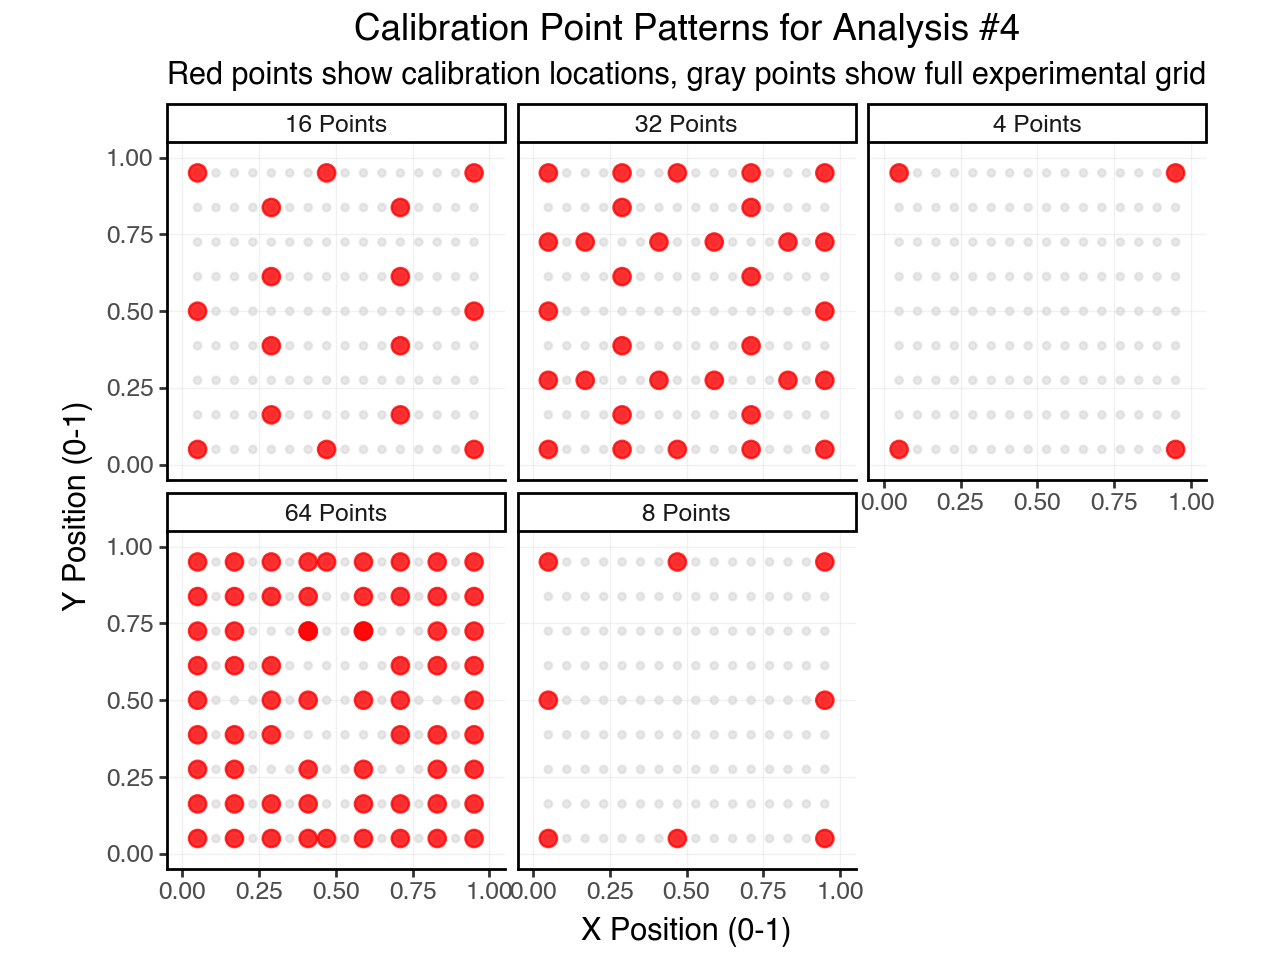

In [ ]:
def visualize_calibration_grids(calibration_point_sets):
    """
    Create a visualization of all calibration point patterns using plotnine/ggplot.
    Shows the different calibration grids in a faceted plot.
    """
    # Create the full experimental grid for background reference
    x_positions = [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95]
    y_positions = [5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95]

    # Create background grid data
    background_grid = []
    for x in x_positions:
        for y in y_positions:
            background_grid.append({
                'x': x/100.0,
                'y': y/100.0,
                'type': 'Background Grid'
            })

    # Create calibration points data
    cal_points_data = []
    for n_points, points_tensor in calibration_point_sets.items():
        points = points_tensor.numpy()
        for point in points:
            cal_points_data.append({
                'x': point[0],
                'y': point[1],
                'n_points': f"{n_points} Points",
                'type': 'Calibration Point'
            })

    # Create DataFrames
    background_df = pd.DataFrame(background_grid)
    cal_points_df = pd.DataFrame(cal_points_data)

    # Create the plot
    plot = (
        ggplot()
        # Add background grid points for reference
        + geom_point(background_df, aes(x='x', y='y'),
                    color='lightgray', size=1, alpha=0.5)
        # Add calibration points
        + geom_point(cal_points_df, aes(x='x', y='y'),
                    color='red', size=3, alpha=0.8)
        # Facet by number of points
        + facet_wrap('~n_points', ncol=3)
        # Formatting
        + scale_y_reverse()  # Match eye-tracking coordinate system (0,0 at top-left)
        + scale_x_continuous(limits=(0, 1), breaks=[0, 0.25, 0.5, 0.75, 1.0])
        + scale_y_continuous(limits=(0, 1), breaks=[0, 0.25, 0.5, 0.75, 1.0])
        + labs(
            title='Calibration Point Patterns for Analysis #4',
            subtitle='Red points show calibration locations, gray points show full experimental grid',
            x='X Position (0-1)',
            y='Y Position (0-1)'
        )
        + theme_classic()
        + theme(
            plot_title=element_text(hjust=0.5),
            plot_subtitle=element_text(hjust=0.5),
            aspect_ratio=1,  # Square plots to match screen aspect
            panel_grid_major=element_line(color='lightgray', size=0.5, alpha=0.3),
            panel_grid_minor=element_blank()
        )
    )

    return plot

# Create and display the calibration grid visualization
cal_grid_plot = visualize_calibration_grids(calibration_point_sets)
#cal_grid_plot.save('analysis_4_calibration_grids.png', width=15, height=10, dpi=150)
cal_grid_plot

In [ ]:
def create_masked_dataset_with_custom_cal_points(dataset, calibration_points):
    """
    Create masked dataset with custom calibration points.
    Always uses phase 1 for calibration and phase 2 for testing.
    """
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, phase, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    def add_masks_to_batch(images, phase, coords, subject_ids):
        actual_batch_size = tf.shape(images)[0]

        # Create phase masks
        phase1_mask = tf.cast(tf.equal(phase, 1), tf.int8)
        phase2_mask = tf.cast(tf.equal(phase, 2), tf.int8)

        # Create calibration mask for phase 1 points that match our calibration set
        coords_xpand = tf.expand_dims(coords, axis=1)
        cal_xpand = tf.expand_dims(calibration_points, axis=0)
        equality = tf.equal(coords_xpand, cal_xpand)
        matches = tf.reduce_all(equality, axis=-1)
        point_matches = tf.reduce_any(matches, axis=1)
        cal_mask = tf.cast(point_matches, dtype=tf.int8) * phase1_mask

        # Target mask: ALL phase 2 points
        target_mask = phase2_mask

        # Pad to fixed size
        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(coords, [[0, MAX_TARGETS - actual_batch_size], [0, 0]])
        padded_cal_mask = tf.pad(cal_mask, [[0, MAX_TARGETS - actual_batch_size]])
        padded_target_mask = tf.pad(target_mask, [[0, MAX_TARGETS - actual_batch_size]])

        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(padded_cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(padded_target_mask, [MAX_TARGETS])

        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids[0]

    masked_dataset = grouped_dataset.map(
        lambda imgs, phase, coords, subj_ids: add_masks_to_batch(imgs, phase, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset

def analyze_calibration_point_effects():
    """
    Run analysis with different numbers of calibration points and create comprehensive DataFrame.
    """
    all_results = []

    for n_points, cal_points in calibration_point_sets.items():
        print(f"\nAnalyzing with {n_points} calibration points...")

        # Create dataset with this calibration set
        masked_dataset = create_masked_dataset_with_custom_cal_points(test_data_rescaled, cal_points)

        # Prepare for model input
        test_dataset = masked_dataset.map(
            prepare_model_inputs,
            num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE)

        # Generate predictions
        print(f"Generating predictions for {n_points} calibration points...")
        predictions = full_model.predict(test_dataset.batch(5), verbose=0)

        # Process results for each subject
        for subject_idx, (pred_batch, ds_batch) in enumerate(zip(predictions, test_dataset.batch(1).as_numpy_iterator())):
            subject_id = subject_ids[subject_idx]
            actual_coords = ds_batch[1].squeeze()
            target_mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

            # Filter by target mask to get only phase 2 points
            pred_coords = pred_batch[target_mask == 1]
            actual_coords_filtered = actual_coords[target_mask == 1]

            # Skip subjects with insufficient data
            if len(pred_coords) < 96:  # Minimum threshold for reliable analysis
                continue

            # Calculate errors for all target points
            errors = []
            for pred_coord, actual_coord in zip(pred_coords, actual_coords_filtered):
                error = normalized_weighted_euc_dist(
                    np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                    np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
                )
                errors.append(float(error.numpy()[0]))

            # Calculate mean error for this subject and calibration set
            mean_error = np.mean(errors)

            all_results.append({
                'subject_id': subject_id,
                'mean_error': mean_error,
                'n_calibration_points': n_points,
                'n_test_points': len(errors)
            })

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    print(f"\nAnalysis complete! Generated {len(results_df)} rows across {len(results_df['subject_id'].unique())} unique subjects")
    print(f"Calibration point counts tested: {sorted(results_df['n_calibration_points'].unique())}")

    return results_df

# Run the analysis
calibration_analysis_df = analyze_calibration_point_effects()
calibration_analysis_df.head(20)


Analyzing with 4 calibration points...
Generating predictions for 4 calibration points...


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



Analyzing with 8 calibration points...
Generating predictions for 8 calibration points...

Analyzing with 16 calibration points...
Generating predictions for 16 calibration points...

Analyzing with 16 calibration points...
Generating predictions for 16 calibration points...

Analyzing with 32 calibration points...
Generating predictions for 32 calibration points...

Analyzing with 32 calibration points...
Generating predictions for 32 calibration points...

Analyzing with 64 calibration points...
Generating predictions for 64 calibration points...

Analyzing with 64 calibration points...
Generating predictions for 64 calibration points...


2025-05-27 18:44:49.034123: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Analysis complete! Generated 1135 rows across 227 unique subjects
Calibration point counts tested: [np.int64(4), np.int64(8), np.int64(16), np.int64(32), np.int64(64)]


,subject_id,mean_error,n_calibration_points,n_test_points
0,2544019960324,3.377018,4,144
1,1545426725871,5.835056,4,144
2,2389290464191,7.870199,4,144
3,13389585215,5.670382,4,144
4,190860173358,9.785312,4,144
5,2768461212563,20.162152,4,144
6,556052438853,3.374898,4,144
7,505133040007,6.402263,4,144
8,1545299779492,31.542712,4,144
9,2422749446868,5.654827,4,144


In [ ]:
# Display summary statistics
print("Summary of calibration analysis:")
print(f"Total rows: {len(calibration_analysis_df)}")
print(f"Unique subjects: {len(calibration_analysis_df['subject_id'].unique())}")
print(f"Calibration point counts: {sorted(calibration_analysis_df['n_calibration_points'].unique())}")

# Show mean error by calibration point count
summary_stats = (
    calibration_analysis_df
    .groupby('n_calibration_points')
    .agg({
        'mean_error': ['mean', 'std', 'count'],
        'subject_id': 'nunique'
    })
    .round(4)
)

print("\nMean error by number of calibration points:")
print(summary_stats)

Summary of calibration analysis:
Total rows: 1135
Unique subjects: 227
Calibration point counts: [np.int64(4), np.int64(8), np.int64(16), np.int64(32), np.int64(64)]

Mean error by number of calibration points:
                     mean_error               subject_id
                           mean     std count    nunique
n_calibration_points                                    
4                       13.3803  9.2170   227        227
8                       11.4759  7.9133   227        227
16                      10.3190  6.8832   227        227
32                       9.8874  6.8283   227        227
64                       9.6188  6.8410   227        227


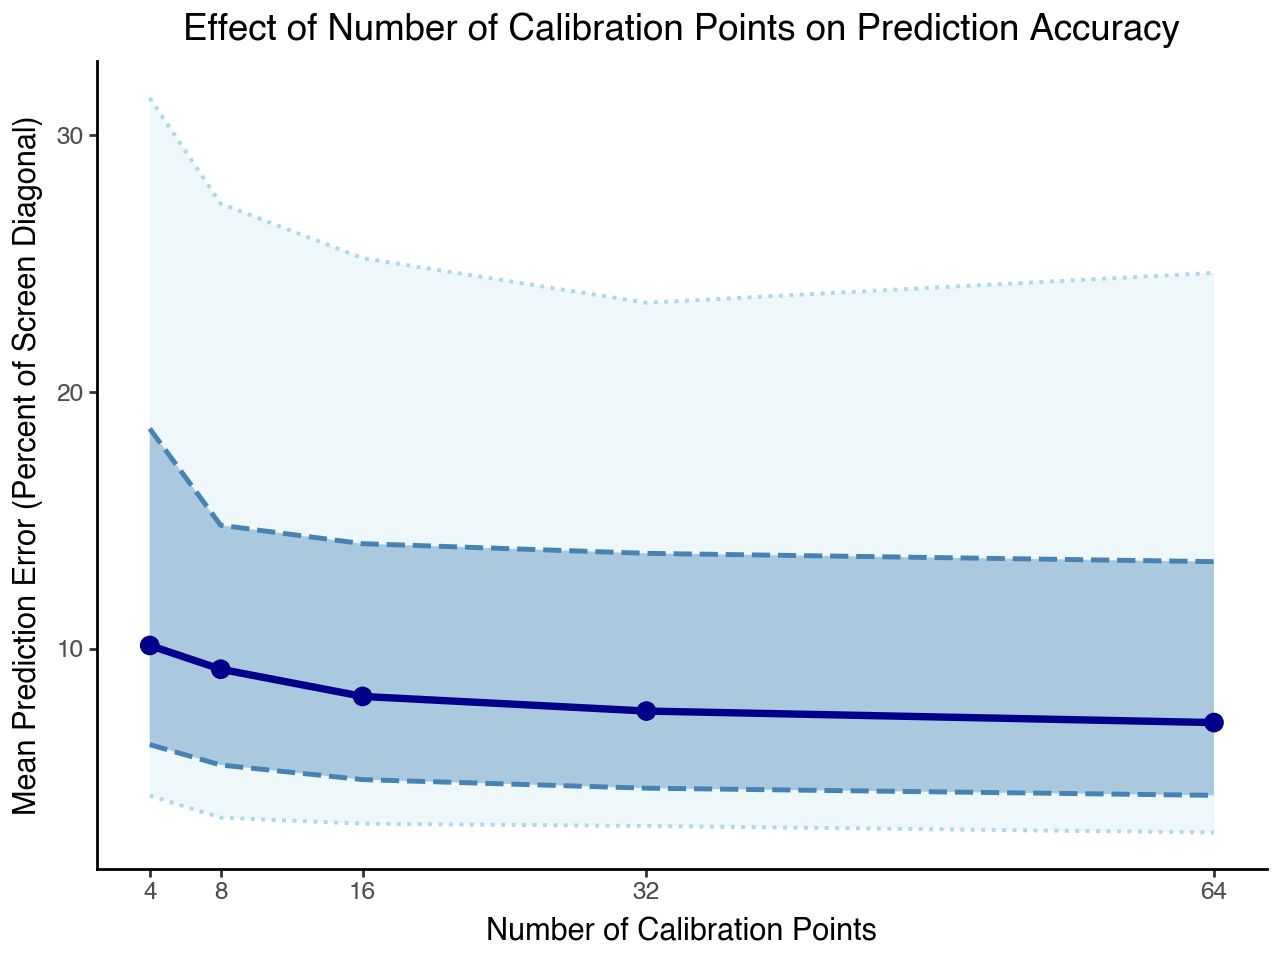

In [ ]:
# Create visualization of calibration point effect with ribbons
import numpy as np

# Calculate percentiles for each calibration point count
cal_summary_stats = []
for n_points in sorted(calibration_analysis_df['n_calibration_points'].unique()):
    subset = calibration_analysis_df[calibration_analysis_df['n_calibration_points'] == n_points]['mean_error']
    cal_summary_stats.append({
        'n_calibration_points': n_points,
        'median': np.percentile(subset, 50),
        'p25': np.percentile(subset, 25),
        'p75': np.percentile(subset, 75),
        'p5': np.percentile(subset, 5),
        'p95': np.percentile(subset, 95)
    })

cal_summary_df = pd.DataFrame(cal_summary_stats)

cal_analysis_plot = (
    ggplot(cal_summary_df, aes(x='n_calibration_points'))
    # Outer ribbon (5th-95th percentile)
    + geom_ribbon(aes(ymin='p5', ymax='p95'), alpha=0.2, fill='lightblue')
    # Inner ribbon (25th-75th percentile)
    + geom_ribbon(aes(ymin='p25', ymax='p75'), alpha=0.4, fill='steelblue')
    # Median line
    + geom_line(aes(y='median'), color='darkblue', size=1.5)
    + geom_point(aes(y='median'), color='darkblue', size=3)
    # 25th and 75th percentile lines
    + geom_line(aes(y='p25'), color='steelblue', size=1, linetype='dashed')
    + geom_line(aes(y='p75'), color='steelblue', size=1, linetype='dashed')
    # 5th and 95th percentile lines
    + geom_line(aes(y='p5'), color='lightblue', size=0.8, linetype='dotted')
    + geom_line(aes(y='p95'), color='lightblue', size=0.8, linetype='dotted')
    + labs(
        title='Effect of Number of Calibration Points on Prediction Accuracy',
        x='Number of Calibration Points',
        y='Mean Prediction Error (Percent of Screen Diagonal)'
    )
    + theme_classic()
    + theme(plot_title=element_text(hjust=0.5))
    + scale_x_continuous(breaks=[4, 8, 16, 32, 64])
)

cal_analysis_plot

In [ ]:
# Save the plot and upload to W&B
cal_analysis_plot.save('analysis_4_calibration_effect.png', width=12, height=8, dpi=150)

# Create W&B table with the calibration analysis data
cal_analysis_table = wandb.Table(
    columns=["subject_id", "mean_error", "n_calibration_points", "n_test_points"],
    data=calibration_analysis_df.values.tolist()
)

# Log to W&B
wandb.log({
    "analysis_4_calibration_effect_plot": wandb.Image('analysis_4_calibration_effect.png'),
    "analysis_4_calibration_data": cal_analysis_table
})

# Analysis #5: Spatial Accuracy Heatmaps by Calibration Set Size

Analyze prediction accuracy by spatial location for each calibration set size to understand how the number of calibration points affects accuracy across different screen regions.

In [ ]:
def create_spatial_accuracy_dataset():
    """
    Create a detailed dataset with spatial coordinates and errors for each calibration set.
    This function analyzes each calibration point set and stores individual point errors with locations.
    """
    all_spatial_data = []

    for n_points, cal_points in calibration_point_sets.items():
        print(f"\nGenerating spatial data for {n_points} calibration points...")

        # Create dataset with this calibration set
        masked_dataset = create_masked_dataset_with_custom_cal_points(test_data_rescaled, cal_points)

        # Prepare for model input
        test_dataset = masked_dataset.map(
            prepare_model_inputs,
            num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE)

        # Generate predictions
        predictions = full_model.predict(test_dataset.batch(5), verbose=0)

        # Process results for each subject
        for subject_idx, (pred_batch, ds_batch) in enumerate(zip(predictions, test_dataset.batch(1).as_numpy_iterator())):
            subject_id = subject_ids[subject_idx]
            actual_coords = ds_batch[1].squeeze()
            target_mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

            # Filter by target mask to get only phase 2 points
            pred_coords = pred_batch[target_mask == 1]
            actual_coords_filtered = actual_coords[target_mask == 1]

            # Skip subjects with insufficient data
            if len(pred_coords) < 96:
                continue

            # Store individual point errors with locations
            for pred_coord, actual_coord in zip(pred_coords, actual_coords_filtered):
                error = normalized_weighted_euc_dist(
                    np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                    np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
                )

                all_spatial_data.append({
                    'subject_id': subject_id,
                    'x_actual': actual_coord[0],
                    'y_actual': actual_coord[1],
                    'x_predicted': pred_coord[0],
                    'y_predicted': pred_coord[1],
                    'error': float(error.numpy()[0]),
                    'n_calibration_points': n_points
                })

    spatial_df = pd.DataFrame(all_spatial_data)
    print(f"\nSpatial analysis complete! Generated {len(spatial_df)} individual point predictions")
    return spatial_df

# Generate the spatial accuracy dataset
spatial_accuracy_df = create_spatial_accuracy_dataset()

In [ ]:
def create_spatial_accuracy_grid(spatial_df):
    """
    Create a grid-based summary of spatial accuracy for heatmap visualization.
    Groups nearby points and calculates mean error for each grid cell.
    """
    # Create grid boundaries - using the experimental grid positions
    x_positions = [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95]
    y_positions = [5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95]

    # Convert to 0-1 scale
    x_grid = [x/100.0 for x in x_positions]
    y_grid = [y/100.0 for y in y_positions]

    # Function to find nearest grid point
    def find_nearest_grid_point(x, y):
        x_idx = min(range(len(x_grid)), key=lambda i: abs(x_grid[i] - x))
        y_idx = min(range(len(y_grid)), key=lambda i: abs(y_grid[i] - y))
        return x_grid[x_idx], y_grid[y_idx]

    # Add grid coordinates to the dataframe
    spatial_df_grid = spatial_df.copy()
    grid_coords = [find_nearest_grid_point(row['x_actual'], row['y_actual'])
                   for _, row in spatial_df.iterrows()]

    spatial_df_grid['x_grid'] = [coord[0] for coord in grid_coords]
    spatial_df_grid['y_grid'] = [coord[1] for coord in grid_coords]

    # Calculate mean error for each grid cell and calibration set
    grid_summary = (
        spatial_df_grid
        .groupby(['n_calibration_points', 'x_grid', 'y_grid'])
        .agg({
            'error': ['mean', 'count'],
            'subject_id': 'nunique'
        })
        .reset_index()
    )

    # Flatten column names
    grid_summary.columns = ['n_calibration_points', 'x_grid', 'y_grid', 'mean_error', 'n_observations', 'n_subjects']

    # Filter out cells with too few observations for reliable estimates
    grid_summary_filtered = grid_summary[grid_summary['n_observations'] >= 10].copy()

    return grid_summary_filtered

# Create the grid-based summary
spatial_grid_df = create_spatial_accuracy_grid(spatial_accuracy_df)
print(f"Grid summary created with {len(spatial_grid_df)} cells")
print(f"Calibration sets: {sorted(spatial_grid_df['n_calibration_points'].unique())}")

In [ ]:
def create_spatial_heatmap():
    """
    Create a comprehensive heatmap showing prediction accuracy across spatial locations
    for each calibration set size.
    """
    # Prepare the data with proper labels
    plot_data = spatial_grid_df.copy()
    plot_data['cal_label'] = plot_data['n_calibration_points'].apply(lambda x: f"{x} Cal Points")

    # Create the heatmap plot
    heatmap_plot = (
        ggplot(plot_data, aes(x='x_grid', y='y_grid', fill='mean_error'))
        + geom_point(size=8, shape='s')  # Square points for heatmap effect
        + facet_wrap('~cal_label', ncol=3)
        + scale_y_reverse()  # Match eye-tracking coordinates (0,0 at top-left)
        + scale_x_continuous(
            limits=(0, 1),
            breaks=[0, 0.25, 0.5, 0.75, 1.0],
            labels=['0', '0.25', '0.5', '0.75', '1.0']
        )
        + scale_y_continuous(
            limits=(0, 1),
            breaks=[0, 0.25, 0.5, 0.75, 1.0],
            labels=['0', '0.25', '0.5', '0.75', '1.0']
        )
        + scale_fill_manual(
            values=['#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7',
                   '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'],
            name='Mean\nPrediction\nError\n(%)'
        )
        + labs(
            title='Spatial Distribution of Prediction Accuracy by Calibration Set Size',
            subtitle='Heatmap showing mean prediction error across screen locations',
            x='Horizontal Position (0-1)',
            y='Vertical Position (0-1)'
        )
        + theme_classic()
        + theme(
            plot_title=element_text(hjust=0.5, size=14),
            plot_subtitle=element_text(hjust=0.5, size=12),
            aspect_ratio=9/16,  # Match screen aspect ratio
            panel_grid_major=element_line(color='lightgray', size=0.3, alpha=0.5),
            panel_grid_minor=element_blank(),
            legend_position='right'
        )
    )

    return heatmap_plot

# Create the spatial heatmap
spatial_heatmap = create_spatial_heatmap()
spatial_heatmap

In [ ]:
def create_difference_heatmap():
    """
    Create a heatmap showing the improvement in accuracy from 4 to 64 calibration points.
    """
    # Calculate differences between 4 and 64 calibration points
    cal_4_data = spatial_grid_df[spatial_grid_df['n_calibration_points'] == 4][['x_grid', 'y_grid', 'mean_error']].copy()
    cal_64_data = spatial_grid_df[spatial_grid_df['n_calibration_points'] == 64][['x_grid', 'y_grid', 'mean_error']].copy()

    # Merge to get differences
    diff_data = cal_4_data.merge(cal_64_data, on=['x_grid', 'y_grid'], suffixes=('_4cal', '_64cal'))
    diff_data['error_improvement'] = diff_data['mean_error_4cal'] - diff_data['mean_error_64cal']

    # Create difference heatmap
    diff_plot = (
        ggplot(diff_data, aes(x='x_grid', y='y_grid', fill='error_improvement'))
        + geom_point(size=12, shape='s')
        + scale_y_reverse()
        + scale_x_continuous(limits=(0, 1), breaks=[0, 0.25, 0.5, 0.75, 1.0])
        + scale_y_continuous(limits=(0, 1), breaks=[0, 0.25, 0.5, 0.75, 1.0])
        + scale_fill_manual(
            values=['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7',
                   '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061'],
            name='Error\nReduction\n(%)'
        )
        + labs(
            title='Spatial Improvement from 4 to 64 Calibration Points',
            subtitle='Positive values indicate better accuracy with more calibration points',
            x='Horizontal Position (0-1)',
            y='Vertical Position (0-1)'
        )
        + theme_classic()
        + theme(
            plot_title=element_text(hjust=0.5, size=14),
            plot_subtitle=element_text(hjust=0.5, size=12),
            aspect_ratio=9/16,
            panel_grid_major=element_line(color='lightgray', size=0.3, alpha=0.5),
            legend_position='right'
        )
    )

    return diff_plot

# Create the improvement heatmap
improvement_heatmap = create_difference_heatmap()
improvement_heatmap

In [ ]:
# Save plots and upload to W&B
spatial_heatmap.save('analysis_5_spatial_heatmap.png', width=15, height=10, dpi=150)
improvement_heatmap.save('analysis_5_improvement_heatmap.png', width=10, height=8, dpi=150)

# Create comprehensive spatial data table for W&B
spatial_data_table = wandb.Table(
    columns=["subject_id", "x_actual", "y_actual", "x_predicted", "y_predicted",
             "error", "n_calibration_points"],
    data=spatial_accuracy_df.values.tolist()
)

# Create grid summary table
grid_summary_table = wandb.Table(
    columns=["n_calibration_points", "x_grid", "y_grid", "mean_error",
             "n_observations", "n_subjects"],
    data=spatial_grid_df.values.tolist()
)

# Log to W